<a href="https://colab.research.google.com/github/ruhanaazam/gp_transfer/blob/main/VanillaGPTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!cd drive

In [3]:
!pip install gpytorch
!pip install botorch

In [4]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import gpytorch
from botorch.utils.transforms import normalize, standardize
import matplotlib.pyplot as plt

from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP, MixedSingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms import Standardize, Normalize
from botorch.utils.transforms import normalize, standardize
from botorch.fit import fit_gpytorch_mll

import pickle

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
  base_path = "/content/drive/My Drive/Colab Notebooks/Transfer_Coh2"

In [6]:
def surfacePlot(model, title = "Your Function" ,n=900):
    '''
    Plots your (true or estimated) coheritability function.
    model: function that takes in two wavelength and outputs coh2 (estimate)
    n: n**2 is the number of points to plot the surface
    '''
    # Generate data for the plot
    x1 = torch.linspace(0, 1, n)
    x2 = torch.linspace(0, 1, n)
    X1, X2 = torch.meshgrid(x1, x2)
    X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T

    Z = model(X.to(device)).cpu().detach().numpy()

    # Create a contour plot
    plt.contourf(X1, X2, Z.reshape(n, n), cmap='viridis')
    plt.colorbar(label='Function Value')

    #plot top 1%
    #threshold = np.percentile(Z, 99)
    #threshold = torch.kthvalue(Z.flatten(), int(0.99 * n * n)).values
    #plt.contour(X1, X2, Z.reshape(n, n), levels=[threshold], colors='red', linewidths=2)

    # Add labels and title
    plt.xlabel('Wavelength 1')
    plt.ylabel('Wavelength 2')
    plt.title(title)

    # Show the plot
    plt.show()
    return

In [7]:
def getTaskID(trait, crop="Sorghum"):
    assert crop == "Sorghum", "Does not handles ids for from that are not Sorghum yet."
    ids = {"narea": 1, "sla": 2, "pn": 3, "ps": 4}
    return ids[trait]

In [8]:
def loadTasks(tasks):
    taskData = []
    for trait in tasks:
        #read raw task file
        data = pd.read_csv(f"/content/drive/My Drive/Colab Notebooks/Transfer_Coh2/data/{trait}_coh2.csv")
        data = torch.tensor(data.values)

        #format data for supervised training, each row (taskid, wave1, wave2, coh2)
        n = torch.ones(data.shape[0], dtype=torch.float32)
        col_index =  torch.arange(data.shape[0], dtype=torch.float32)
        col_index = torch.outer(n, col_index)
        row_index = col_index.T

        #stack wave1, wave2 and coh2 tensors together
        task_ids = torch.ones(data.shape) * getTaskID(trait)
        flat_data = torch.stack([task_ids.flatten(), col_index.flatten(), row_index.flatten(), data.flatten()])
        flat_data = flat_data.T

        #remove all rows with nans
        nan_mask = torch.isnan(flat_data)
        nan_in_rows = torch.any(nan_mask, dim=1)
        clean = flat_data[~nan_in_rows]

        taskData.append(clean)

    #combine all tasks
    all_tasks = torch.cat(taskData)
    return all_tasks[:, :3], all_tasks[:, -1]

In [9]:
# #Load data (by tasks)
# X, Y = loadTasks(["narea", "sla", "pn", "ps"])

# #Split into train and validation sets
# seed = 1234
# split = 0.85
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=split, random_state=seed)

# # Convert NumPy arrays to PyTorch tensors
# x_train = torch.tensor(x_train, dtype=torch.float64)
# y_train = torch.tensor(y_train, dtype=torch.float64)
# x_test = torch.tensor(x_test, dtype=torch.float64)
# y_test = torch.tensor(y_test, dtype=torch.float64)

In [10]:
#should have one result dictionary for each task...
seed = 1234
split = 0.85

#option_n = [i for i in range(500, 1500+1, 500)]
option_n = [750, 900]
M = 1000 #validation set size
tasks = ["narea", "sla", "pn", "ps"]

In [11]:
#train SingleTaskGP

results = {}
for task in tasks:
  #load data for single task and split into training and test
  X, Y = loadTasks([task])
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=split, random_state=seed)
  x_train, x_test, y_train, y_test = x_train[:option_n[-1]], x_test[:M], y_train[:option_n[-1]], y_test[:M]
  del X
  del Y

  # normalize input, standardize y
  c_xtest = normalize(x_test[:M, 1:], torch.tensor([[0,0],[2150,2150]])) #continous part
  y_test_standardized = standardize(y_test[:M]).reshape(-1,1)

  c_xtrain = normalize(x_train[:, 1:], torch.tensor([[0,0],[2150,2150]])) #continous part
  y_train_standardized = standardize(y_train).reshape(-1,1)


  task_result = {"val_loss":[],
           "train_loss": []
           }
  for N in option_n:
    # Train the model ...
    model = SingleTaskGP(c_xtrain[:N], y_train_standardized[:N])

    # Use Exact Marginal Log Likelihood as the loss
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # Fit the model
    fit_gpytorch_mll(mll, )

    #save the losses
    y_hat = model.posterior(c_xtest).mean
    val_loss = torch.mean((y_test_standardized - y_hat)**2).item()
    task_result["val_loss"].append(val_loss)

    y_hat = model.posterior(c_xtrain).mean
    train_loss = torch.mean((y_train_standardized - y_hat)**2).item()
    task_result["train_loss"].append(train_loss)

  results[task] = task_result

  #save results
  with open(f'{base_path}/results/vanillaGP_single.pkl', 'wb') as pickle_file:
    pickle.dump(results, pickle_file)

  #save model
  torch.save(model.state_dict(), f'{base_path}/models/vanilla_gp_{N}.pth')

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0122], dtype=torch.float64), std = tensor([0.9818], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0075], dtype=torch.float64), std = tensor([0.9804], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0108], dtype=torch.float64), std = tensor([0.9737], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10

In [12]:
#re-load your results
with open(f'{base_path}/results/vanillaGP_single.pkl', 'rb') as pickle_file:
    results = pickle.load(pickle_file)

#re-load model here
model_N = option_n[-1] # num training data in desired model
state_dict = torch.load(f'{base_path}/models/vanilla_gp_{model_N}.pth')
model = SingleTaskGP(c_xtrain, y_train_standardized)  # Create a new GP model
model.load_state_dict(state_dict)

<All keys matched successfully>

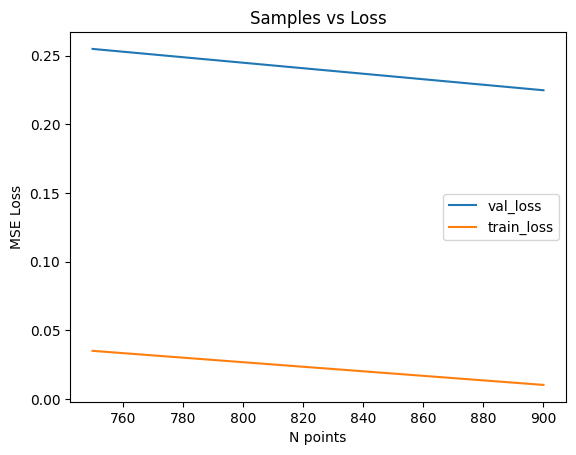

In [13]:
#plot training and validation loss
for task in ["ps"]:
  task_dic = results[task]

  # Create a line plot
  plt.plot(option_n, task_dic["val_loss"], label = "val_loss")
  plt.plot(option_n, task_dic["train_loss"], label = "train_loss")

# Add labels and title
plt.xlabel('N points')
plt.ylabel('MSE Loss')
plt.title('Samples vs Loss')
plt.legend()

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


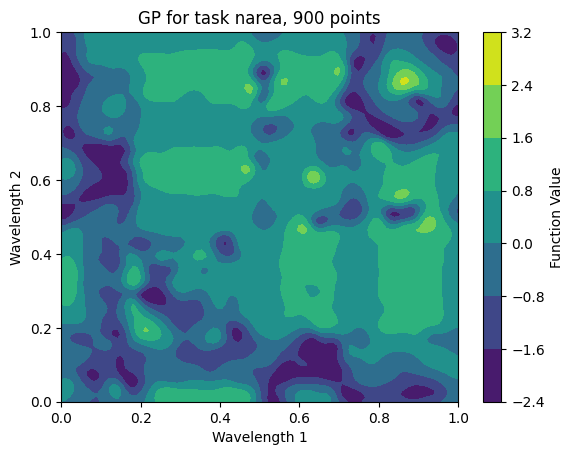

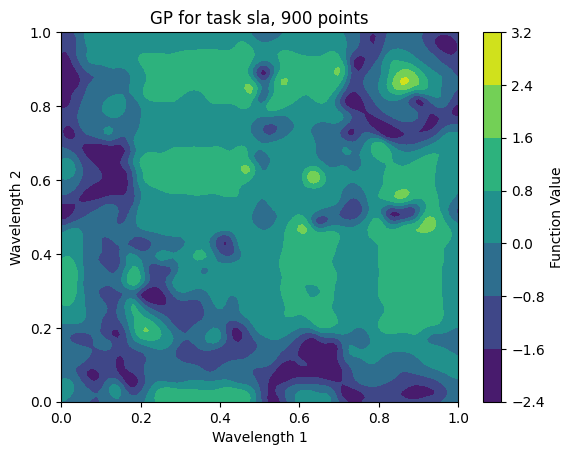

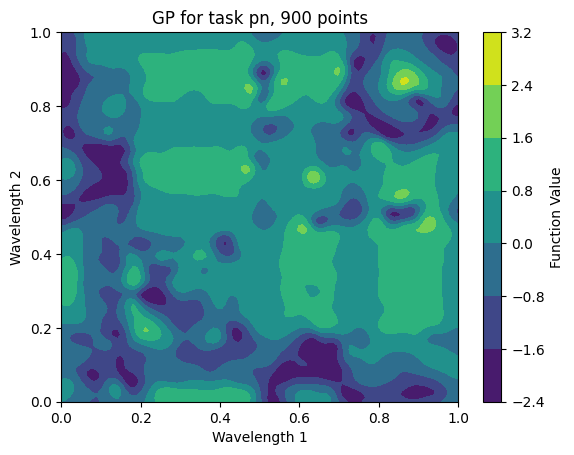

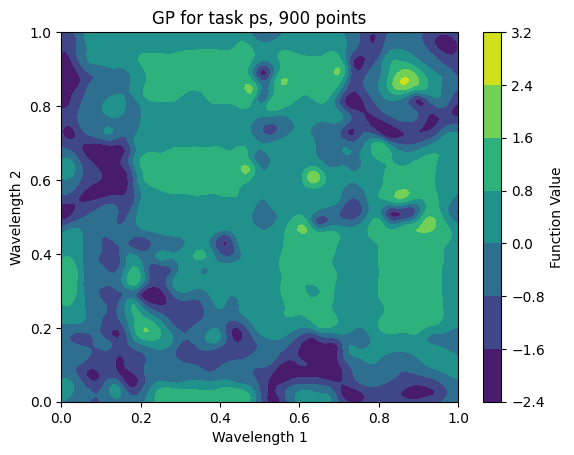

In [14]:
for task in tasks:
  def modelWrapper(X):
    inp = X
    return model.posterior(inp).mean

  surfacePlot(modelWrapper, title=f"GP for task {task}, {N} points", n=100)